In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, roc_curve, auc
import tensorflow as tf
import re
from nltk.corpus import stopwords 
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv("amazon_alexa.tsv", header = 0, delimiter = '\t')

#df["feedback"] = np.where(df["feedback"] == 1,'S','N')
df.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [3]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text


In [4]:
df['verified_reviews'] = df['verified_reviews'].apply(clean_text)

In [5]:
documents = df.verified_reviews
target = df.feedback
#le = LabelEncoder()
#target = le.fit_transform(target)
#target = target.reshape(-1,1)

In [6]:
X_train,X_test,Y_train,Y_test = train_test_split(documents,target,test_size=0.30)

In [7]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [59]:
def LSTM():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    

    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)

    
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model


def auroc(y_true, y_pred):
    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)


In [49]:
prob_loss = ['categorical_crossentropy','binary_crossentropy']

optimizer=['sgd','adam','adadelta','adagrad','adamax']

def compile_run(loss,optimizer,epoch):
    tf.keras.backend.clear_session()
    model = RNN()
    model.compile(loss=loss, 
                  optimizer=optimizer,
                  metrics=[tf.keras.metrics.AUC()])
       
    
    model.fit(sequences_matrix,
              Y_train,
              batch_size=128,
              epochs=epoch,
              validation_split=0.1,
              callbacks=[EarlyStopping(monitor='val_loss',min_delta = 0.0000000001)])
    
    return model

In [41]:
epoch = 10

for loss_ in prob_loss:
    
    for optimizer_ in optimizer:
        
        print('loss: ',loss_)
        print('optimizer: ',optimizer_)
        print(' ')

        
        compile_run(loss_,optimizer_,epoch)
            
        print(' ')
        print(' ')

loss:  categorical_crossentropy
optimizer:  sgd
 
Epoch 1/10
16/16 [==============================] - 5s 182ms/step - loss: 0.0000e+00 - auc: 0.5078 - val_loss: 0.0000e+00 - val_auc: 0.5024
Epoch 2/10
16/16 [==============================] - 2s 129ms/step - loss: 0.0000e+00 - auc: 0.4974 - val_loss: 0.0000e+00 - val_auc: 0.4952
 
 
loss:  categorical_crossentropy
optimizer:  adam
 
Epoch 1/10
16/16 [==============================] - 5s 188ms/step - loss: 0.0000e+00 - auc: 0.4972 - val_loss: 0.0000e+00 - val_auc: 0.2933
Epoch 2/10
16/16 [==============================] - 2s 142ms/step - loss: 0.0000e+00 - auc: 0.4759 - val_loss: 0.0000e+00 - val_auc: 0.5000
 
 
loss:  categorical_crossentropy
optimizer:  adadelta
 
Epoch 1/10
16/16 [==============================] - 5s 203ms/step - loss: 0.0000e+00 - auc: 0.5720 - val_loss: 0.0000e+00 - val_auc: 0.5711
Epoch 2/10
16/16 [==============================] - 2s 152ms/step - loss: 0.0000e+00 - auc: 0.5509 - val_loss: 0.0000e+00 - val_auc: 0.5

In [60]:
modecompile_run('binary_crossentropy','adam',2)

TypeError: LSTM() takes 0 positional arguments but 1 was given

In [51]:
sequences_test = tok.texts_to_sequences(X_test)
sequences_matrix_test = sequence.pad_sequences(sequences_test,maxlen=max_len)

In [52]:
ynew = model.predict(sequences_matrix_test)

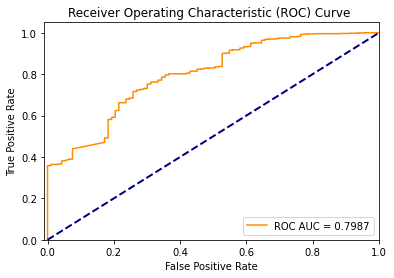

In [54]:
 # Plot AUC Curve
    
fpr, tpr, threshold = roc_curve(Y_test, ynew)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic (ROC) Curve ')
plt.plot(fpr, tpr, color='darkorange', label = 'ROC AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([-0.01, 1])
plt.ylim([0, 1.05])

plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
def plot_confusion_matrix(y_test, y_proba_predicted):
    """
    Plot confusion matrix for a given values of y_test, y_proba_predicted, and threshold
    """
    cm = confusion_matrix(y_test, y_proba_predicted.astype(int))
    classes = ['Neg', 'Pos']

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

In [ ]:

plot_confusion_matrix(Y_test,y_pred,0.3)  